- import lib

In [2]:
# What version of Python do you have?
import sys

from collections import Counter

import tensorflow.keras
import pandas as pd
import sklearn as sk
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
import tensorflow as tf
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import demoji
import datetime

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 1.13.1
Keras Version: 2.2.4-tf

Python 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 1.0.1
Scikit-Learn 0.22.1
GPU is NOT AVAILABLE


- read data

In [2]:
tweet_vector_df = pd.read_csv("./data_vectors/vectors-100-2019-02-06.csv")

- SVD

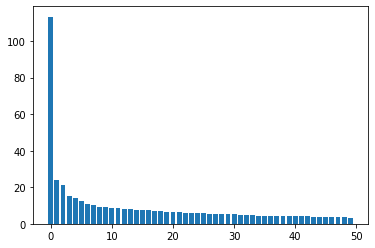

In [3]:
u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
num_of_bars = 50
_ = plt.bar(np.arange(num_of_bars), s[:num_of_bars])

In [4]:
threshold = 15

basis_events = []
for i in range(len(s)):
    if s[i] < threshold: break
    if s[i] >= threshold: basis_events.append(vh[i])

In [5]:
len(basis_events)

4

- project each non-basis vectors onto the basis vectors and aggregate them

In [6]:
aggregated_vector = [0 for i in range(768)]
for idx, tweet in tweet_vector_df.iterrows():
    # iterate through each basis event
    for basis_event in basis_events:
        norm = np.linalg.norm(basis_event)
        aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
#         print(np.dot(tweet.to_list(), basis_event))
#         print("==============")
# print(aggregated_vector)

- assign sentiment class

In [3]:
def sentiment_class(num):
    if num >= 1/3: 
        return 1
    elif num >=-1/3: 
        return 0
    else: 
        return -1
def sentiment_class2(num):
    if num >= 1/15 or num < -1/15: 
        return 11
    else: 
        return 22

- function to aggregate vector with projection

In [33]:
def aggregator(date):
    # read date
    tweet_vector_df = pd.read_csv("./data_vectors/vectors-10000-" + date +".csv")
    tweet_vector_df['sentiment_class'] = tweet_vector_df.sentiment.apply(sentiment_class)
    
    # SMOTE oversampling
    all_rows = tweet_vector_df.values.tolist()
    X = [row[: -1] for row in all_rows]
    y = [row[-1] for row in all_rows]
    sentiment_count = Counter(y)
    if sentiment_count[1] <= 3 or sentiment_count[-1] <= 3:
        # read date
        tweet_vector_df['sentiment_class'] = tweet_vector_df.sentiment.apply(sentiment_class2)

        # SMOTE oversampling
        all_rows = tweet_vector_df.values.tolist()
        X = [row[: -1] for row in all_rows]
        y = [row[-1] for row in all_rows]
    sm = SMOTE(random_state=2, k_neighbors=3)
    X_res, y_res = sm.fit_resample(X, y)
    
    # re-assemble back to dataframe
    tweet_vector_df = pd.DataFrame(X_res)
    tweet_vector_df = tweet_vector_df.rename(columns={768: "sentiment_score"})
    tweet_vector_df['sentiment_class'] = y_res
    
    # print(tweet_vector_df.shape, tweet_vector_df.columns)
    # svd
    u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
    
    # generate basis events
    threshold = 15

    basis_events = []
    for i in range(len(s)):
        if s[i] < threshold: break
        if s[i] >= threshold: basis_events.append(vh[i])
    
    # projection
    aggregated_vector = [0 for i in range(797)]
    for idx, tweet in tweet_vector_df.iterrows():
        # iterate through each basis event
        for basis_event in basis_events:
            norm = np.linalg.norm(basis_event)
            aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
    return np.concatenate((np.array([date]), aggregated_vector))

In [44]:
# plain addition version of aggregator
def aggregator(date):
    # read date
    tweet_vector_df = pd.read_csv("./data_vectors/vectors-10000-" + date +".csv")
    tweet_vector_df['sentiment_class'] = tweet_vector_df.sentiment.apply(sentiment_class)
    
    # SMOTE oversampling
    all_rows = tweet_vector_df.values.tolist()
    X = [row[: -1] for row in all_rows]
    y = [row[-1] for row in all_rows]
    sentiment_count = Counter(y)
    if sentiment_count[1] <= 3 or sentiment_count[-1] <= 3:
        # read date
        tweet_vector_df['sentiment_class'] = tweet_vector_df.sentiment.apply(sentiment_class2)

        # SMOTE oversampling
        all_rows = tweet_vector_df.values.tolist()
        X = [row[: -1] for row in all_rows]
        y = [row[-1] for row in all_rows]
    sm = SMOTE(random_state=2, k_neighbors=3)
    X_res, y_res = sm.fit_resample(X, y)
    
    # re-assemble back to dataframe
    tweet_vector_df = pd.DataFrame(X_res)
    tweet_vector_df = tweet_vector_df.rename(columns={768: "sentiment_score"})
    tweet_vector_df['sentiment_class'] = y_res
    
    # print(tweet_vector_df.shape, tweet_vector_df.columns)
    # svd
    u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
    
    # generate basis events
    threshold = 15

    basis_events = []
    for i in range(len(s)):
        if s[i] < threshold: break
        if s[i] >= threshold: basis_events.append(vh[i])
    
    # projection
    aggregated_vector = [0 for i in range(797)]
    for idx, tweet in tweet_vector_df.iterrows():
        aggregated_vector = np.add(aggregated_vector, tweet.to_list())
    return np.concatenate((np.array([date]), aggregated_vector))

- wrap up

In [31]:
sample_df = pd.read_csv("./data_vectors/vectors-10000-2019-02-06.csv")
sample_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       'num_pos_VB', 'num_pos_NN', 'num_neg_JJ', 'num_neg_RB', 'num_neg_VB',
       'num_neg_NN', 'total_score_JJ', 'total_score_RB', 'total_score_VB',
       'total_score_NN'],
      dtype='object', length=796)

In [28]:
new_row_df.shape

(1, 798)

In [29]:
sample_df.shape

(360, 796)

In [45]:
# Inclusive on both sides
start_date = datetime.date(2019, 2, 6)
end_date = datetime.date(2020, 2, 6)
time_window = (end_date - start_date).days + 1

sample_df = pd.read_csv("./data_vectors/vectors-10000-2019-02-06.csv")

feature_by_date = pd.DataFrame(columns=['date'] + list(sample_df.columns) + ['sentiment_class'])

for single_date in (start_date + datetime.timedelta(n) for n in range(time_window)): 
    this_date = single_date.strftime("%Y-%m-%d")
    new_row_df = pd.DataFrame(aggregator(this_date)).transpose()
    new_row_df = new_row_df.rename(columns={0: "Date"})
    new_row_df.columns = ['date'] + list(sample_df.columns) + ['sentiment_class']
    feature_by_date = pd.concat([feature_by_date, new_row_df], ignore_index=True)
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("finished %s" % this_date)
    sys.stdout.flush()
print("\nall finished")

finished 2020-02-06
all finished


In [46]:
feature_by_date = feature_by_date.rename(columns={"date": "Date"})
feature_by_date.drop(['sentiment_class'], axis=1).to_csv("aggregated_vector.csv", index=False)

In [47]:
feature_by_date

Date                   0                    1                   2  \
0    2019-02-06   71.90306319504995  -101.01909516576698   253.0723628271902   
1    2019-02-07   44.81215441796012   -81.75917134719651  208.08535565315196   
2    2019-02-08   66.55686445061475   -55.48593680256824  151.71953831019212   
3    2019-02-09   45.28615215497312   -41.01671888786713   113.3374474528451   
4    2019-02-10  50.403221528043446   -35.65398807833173   99.40018095137005   
..          ...                 ...                  ...                 ...   
361  2020-02-02   38.13690406243636   -36.51781721971937  103.75717679413866   
362  2020-02-03   405.2354219248957   -350.5719362216814  1302.1730154838363   
363  2020-02-04  255.79010017503984   -290.7583831830573   918.4883451063605   
364  2020-02-05   53.95920289093409   -65.19692748239486  242.14915701896703   
365  2020-02-06  44.277841225192596  -112.83151658863736   258.8508748991166   

                       3                   4                    5  \
0    -17.503856819538957   188.6996398832305   -96.79454926927278   
1    -15.435891661956088  139.44297919086722   -85.84159571481044   
2     -9.212199702018914  130.06653960345886   -70.20032910498622   
3     -9.378766341394345   84.76232492458904   -71.51193532882711   
4    -10.283119746743488    71.2516277293925   -52.95660831549235   
..                   ...                 ...                  ...   
361   -5.473149747226894   73.47723347423762  -61.229333361588736   
362   22.137354308135894   724.7292433278931  -265.60197129680495   
363    48.41174102568469   404.1694716564864   -337.2089452167924   
364  -13.960206329235842  149.70703283448256   -67.12987158432021   
365    -8.30314217904911  168.25884474167077  -107.87466242351555   

                       6                   7                    8  ...  \
0    -28.115628307684275  251.15785155853632   -99.18329614464855  ...   
1    -28.383232203347024  221.92564341289298   -83.43805777212589  ...   
2    -30.366275739495045   190.4251237032718   -63.55789411291774  ...   
3     -8.031286691922395  100.86688083316658   -36.67746653718471  ...   
4    -10.480809747609902   102.2738399931852  -41.695657621452156  ...   
..                   ...                 ...                  ...  ...   
361    1.286786504067909  111.28052513706487  -44.461506380340374  ...   
362  -208.15406521005005  1159.9277393677762   -733.1932023018453  ...   
363  -173.18110090837507   826.2603653157952   -432.2003068106925  ...   
364   -30.03978830107211     213.58389733223   -97.05782471562836  ...   
365  -18.063791810263346   274.4764141909459  -132.38758975005905  ...   

             num_pos_NN          num_neg_JJ          num_neg_RB  \
0     8.616245191234034  48.818011559543976  29.645797874262414   
1     3.260692235289285   92.94195463410671   25.45268103902555   
2    11.202799892433573  34.647003122436665                 0.0   
3                   0.0     11.339530337561                 0.0   
4                   0.0  12.756543649884623  1.4413549193548467   
..                  ...                 ...                 ...   
361  2.5174307637214692    43.3313261713848                 0.0   
362  112.14139845598066   699.0839635777601  39.913999309798406   
363  36.284564631085665   405.3413085643449  124.96705896555629   
364   4.982857907190418   34.39796453389515  28.588686580005014   
365  21.518637839040103   67.55346495936749  20.974097475527053   

            num_neg_VB          num_neg_NN      total_score_JJ  \
0                  0.0   51.52867375402791   21.21396256898961   
1    5.010889570859584   35.10288892433727  24.031710095624163   
2    4.246516380728746    38.1212940638628  16.613835213649725   
3                  0.0   54.64793954033846   5.755708005612059   
4                  0.0   25.80790571710725  11.538205479921645   
..                 ...                 ...                 ...   
361  4.133393918118198   37.68388635908967   10.83851984055945   

- function to aggregate vector without projection

In [ ]:
def aggregator_naive(date):
    # read date
    tweet_vector_df = pd.read_csv("./data_vectors/vectors-100-" + date +".csv")

    basis_events = []
    for i in range(len(s)):
        if s[i] < threshold: break
        if s[i] >= threshold: basis_events.append(vh[i])
    
    # projection
    aggregated_vector = [0 for i in range(768)]
    for idx, tweet in tweet_vector_df.iterrows():
        # iterate through each basis event
        for basis_event in basis_events:
            norm = np.linalg.norm(basis_event)
            aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
    return np.concatenate((np.array([date]), aggregated_vector))